# Introduction to Machine Learning Homework 3

## Instructions

This homework is due before class on **Friday, May 2nd**.

Important notes:
- Please submit the notebook with the output.
- If the answer is not obvious from the printout, please type it as markdown.
- The notebook should be self contained and we should be able to rerun it.
- Import all the libraries that you find necessary to answer the questions.
- If the subquestion is worth 1 point, no half points will be given: full point will be given to the correct answer. Similarly if the question is worth 2, possible points are 0,1,2. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn import set_config
set_config(display="text")

## Question 1

**Total 26 points**

For this question we will use a dataset with the medical details of patients for predicting the onset of diabetes within 5 years. The target is the last column of the dataset,  where value 1 is interpreted as "tested positive for diabetes".

1. Import the csv file "HW3_Q1.csv" into pandas dataframe, check the number of rows, check the data types, view the first 5 rows, and check class distribution  (1pt)
2. Plot a heatmap of the Pearson correlations between each pair of features (with annotations). Which pair of variables has the highest correlation? (1pt)
3.  Split the data into train and test, leaving 20% for the test set. Make sure that the target distribution is the same in train and test set. Set the random_state to 0 (1pt)
4. Using pipeline with randomized search do data standardization, data balancing, and then apply XGBoost (6pts)
- For data balancing test no data balancing, oversampling and SMOTE (with random state set to 0 for both).
- For XGBoost, for learning rate sample uniformly from the interval between 0.03 and 0.1 (including 0.1), for the maximum tree depth, test the values from 4 to 7 (including 7), and for the number of iterations test the values from 300 to 900 (inclusive), in steps of 100.
- Check in total 15 parameter combinations, set random state to 0, do 5 fold cross validation and use f1-score as the criterion for model selection and tuning.

What are the best parameters found?

5. Visualize the original training dataset using TSNE, coloring the classes in different colors and with 70 as the number of neighbors, and visualize the training dataset after employing the resampling method of the best estimator found in step 4, also with classes in different colors and 70 as the number of neighbors. Set the random state to 42 on both. If the best estimator did not employ any sampling method, use SMOTE (2pt)
6. Check the recall of the best model found in step 4 on the test set (1pt) 

For all the interpretation approaches below use the test set. 

7. Check feature importance of the best model obtained in step 4 using permutation feature importance on the test set, permuting each feature 30 times and setting the random state to 42. What are the two most important features? (2pt)
8. With the test set, for two most important features found in step 7, plot partial dependence plot separately for each feature. Explain how the feature impacts the average predicted target value. Plot partial dependence interactive plot for these two features. Approximately for what ranges of values of these features is the lowest average predicted probability of being tested positive for diabetes? (4pt)
9. Find the first point misclassified by the model. What is the probability that it belongs to class 1 found by the model? Use LIME to see the explanation for this prediction by using only 3 features to explain the model, with 200 samples; also, set the random state to 42 when defining the explainer. What are the features that LIME uses to explain the prediction? What are the features that contribute to the wrong class, i.e., the class predicted by the model? (5pt)
10. 
What is the most important feature in the testing set according to Shap. Explain in one sentence how the values of this feature impact the prediction (3pt)

### 1.1.Import the csv file "HW3_Q1.csv" into pandas dataframe, check the number of rows, check the data types, view the first 5 rows, and check class distribution (1pt)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [5]:
df1 = pd.read_csv('HW3_Q1.csv')
#df1

In [6]:
print(f"The number of rows is {df1.shape[0]}.")

The number of rows is 771.


In [7]:
df1.dtypes

num_pregnancy          int64
glucose_conc           int64
blood_pressure         int64
skin_fold              int64
serum                  int64
body_mass            float64
diabetes_pedigree    float64
age                    int64
target                 int64
dtype: object

In [8]:
df1.head(5)

num_pregnancy  glucose_conc  blood_pressure  skin_fold  serum  body_mass  \
0              6           148              72         35      0       33.6   
1              1            85              66         29      0       26.6   
2              8           183              64          0      0       23.3   
3              1            89              66         23     94       28.1   
4              0           137              40         35    168       43.1   

   diabetes_pedigree  age  target  
0              0.627   50       1  
1              0.351   31       0  
2              0.672   32       1  
3              0.167   21       0  
4              2.288   33       1

In [9]:
df1['target'].value_counts()

target
0    500
1    271
Name: count, dtype: int64

In [10]:
df1['target'].value_counts(normalize=True)

target
0    0.648508
1    0.351492
Name: proportion, dtype: float64

In [11]:
#sns.barplot(x = df1['target'].value_counts().index, y = df1['target'].value_counts())
#plt.tight_layout()

### 1.2. Plot a heatmap of the Pearson correlations between each pair of features (with annotations). Which pair of variables has the highest correlation? (1pt)

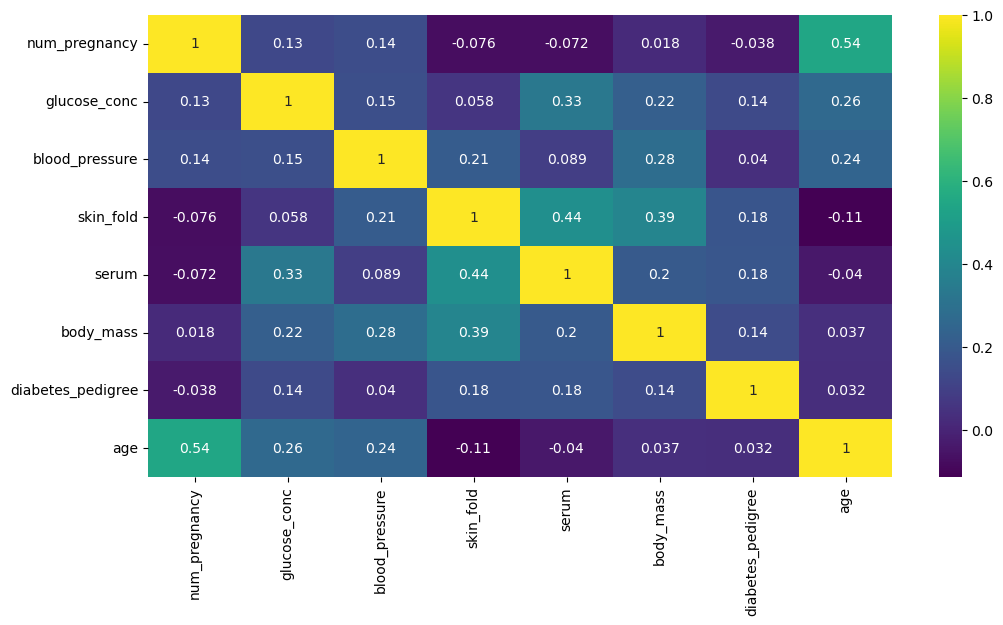

In [12]:
plt.figure(figsize=(12,6))
corr_matrix=df1.drop(columns=['target']).corr(method='pearson')
sns.heatmap( corr_matrix, cmap = 'viridis', annot=True );

In [13]:
corr_abs = corr_matrix.abs().unstack().sort_values(ascending=False)
num_diag_elems=corr_matrix.shape[0]
corr_abs.iloc[:num_diag_elems] 

num_pregnancy      num_pregnancy        1.0
glucose_conc       glucose_conc         1.0
skin_fold          skin_fold            1.0
blood_pressure     blood_pressure       1.0
diabetes_pedigree  diabetes_pedigree    1.0
age                age                  1.0
body_mass          body_mass            1.0
serum              serum                1.0
dtype: float64

After sorting, the top values occur when the feature is correlated with itself; as such, the actual top values are available subsequently.

In [14]:
corr_abs.iloc[num_diag_elems:].head()

num_pregnancy  age              0.544751
age            num_pregnancy    0.544751
serum          skin_fold        0.435989
skin_fold      serum            0.435989
               body_mass        0.392147
dtype: float64

age and num_pregnancy

### 1.3. Split the data into train and test, leaving 20% for the test set. Make sure that the target distribution is the same in train and test set. Set the random_state to 0 (1pt)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns=['target']), df1['target'], stratify= df1['target'],
                                                    test_size=0.2, random_state=0)

### 1.4. Using pipeline with randomized search do data standardization, data balancing, and then apply XGBoost (6pts)

- For data balancing test no data balancing, oversampling and SMOTE (with random state set to 0 for both).
- For XGBoost, for learning rate sample uniformly from the interval between 0.03 and 0.1 (including 0.1), for the maximum tree depth, test the values from 4 to 7 (including 7), and for the number of iterations test the values from 300 to 900 (inclusive), in steps of 100.
- Check in total 15 parameter combinations, set random state to 0, do 5 fold cross validation and use f1-score as the criterion for model selection and tuning.

What are the best parameters found?

In [16]:
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as sp
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [17]:
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('sampling', RandomOverSampler()),
    ('classifier', XGBClassifier(use_label_encoder=False))
])

#############

param_grid = [
    {'sampling': [None, RandomOverSampler(random_state=0), SMOTE(random_state=0)],
    'classifier__n_estimators': [int(x) for x in np.linspace(start = 300, stop = 900, num = 7)],
    #n_estimators alias was used instead of num_iterations to avoid alias warnings.
    # range(300,1000,100) is also valid
    'classifier__learning_rate': sp.uniform(loc=0.03, scale=0.07),
    # [loc, loc + scale].
    'classifier__max_depth': range(4,8)
    }
]

#############

random_xgb = RandomizedSearchCV(pipe, param_grid, cv = 5, scoring = 'f1', n_iter = 15, random_state=0)
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampling', RandomOverSampler()),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                    

In [18]:
random_xgb.best_params_

{'classifier__learning_rate': np.float64(0.08447097256648954),
 'classifier__max_depth': 7,
 'classifier__n_estimators': 300,
 'sampling': SMOTE(random_state=0)}

### 1.5. Visualize the original training dataset using TSNE, coloring the classes in different colors and with 70 as the number of neighbors, and visualize the training dataset after employing the resampling method of the best estimator found in step 4, also with classes in different colors and 70 as the number of neighbors. Set the random state to 42 on both. If the best estimator did not employ any sampling method, use SMOTE (2pt)

In [19]:
best_estimator = random_xgb.best_estimator_
best_estimator['sampling']

SMOTE(random_state=0)

Text(0.5, 1.0, 'Resampled Training Set')

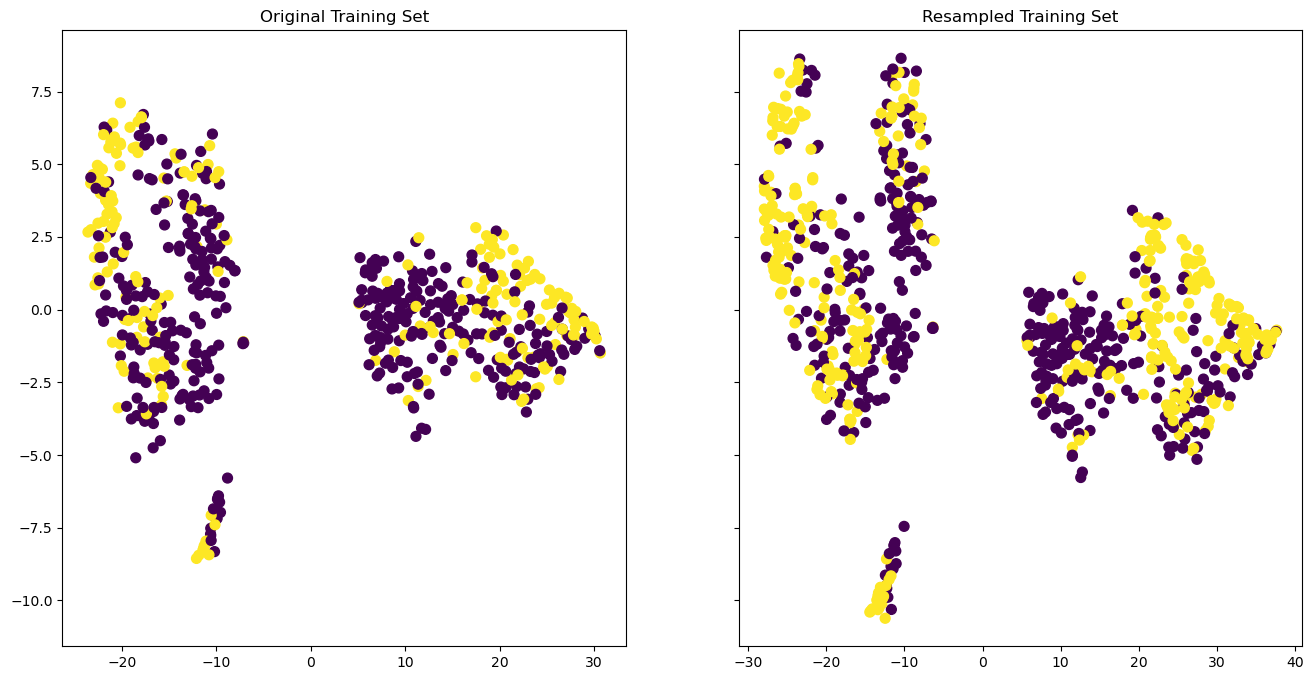

In [20]:
X_resampled, y_resampled = best_estimator['sampling'].fit_resample(X_train, y_train)

from sklearn.manifold import TSNE

fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)

tsne = TSNE(perplexity = 70, random_state=42)
X_tsne = tsne.fit_transform(X_train)

axes[0].scatter(X_tsne[:,0], X_tsne[:,1], s=50, c=y_train, cmap = 'viridis')
axes[0].set_title('Original Training Set')

tsne1 = TSNE(perplexity = 70, random_state=42)
X_tsne1 = tsne.fit_transform(X_resampled)

axes[1].scatter(X_tsne1[:,0], X_tsne1[:,1], s=50, c=y_resampled, cmap = 'viridis')
axes[1].set_title('Resampled Training Set')

Scaling was not mandatory for this question.

### 1.6. Check the recall of the best model found in step 4 on the test set (1pt)

In [21]:
from sklearn.metrics import recall_score

y_pred = random_xgb.predict(X_test)

print('Recall score is', recall_score(y_test, y_pred))

Recall score is 0.5925925925925926


In [22]:
#random_xgb.score(X_test, y_test) this yields the f1-score

### 1.7. Check feature importance of the best model obtained in step 4 using permutation feature importance on the test set, permuting each feature 30 times and setting the random state to 42. What are the two most important features? (2pt)

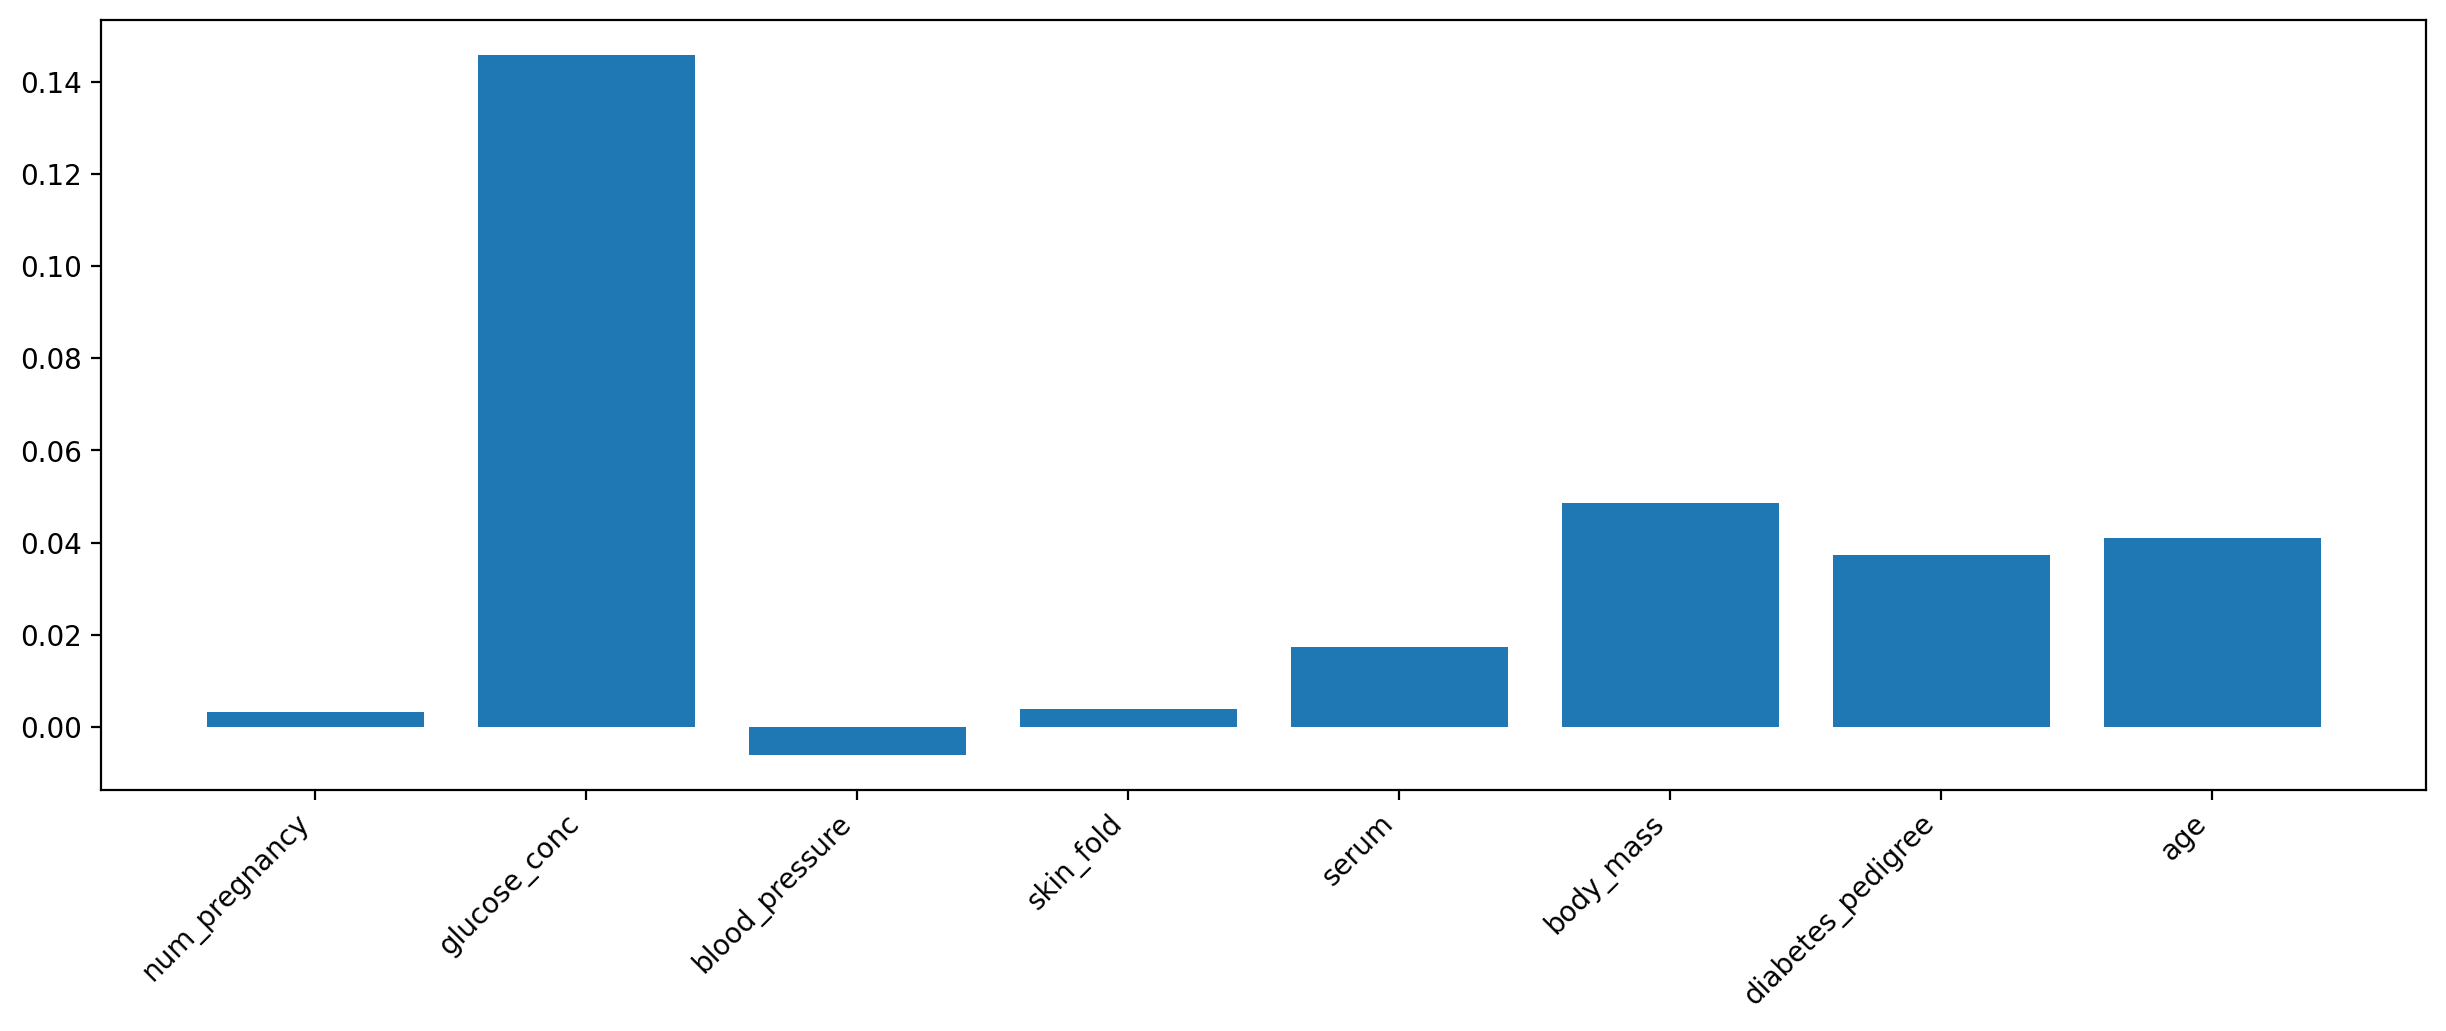

In [23]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(random_xgb.best_estimator_, X_test, y_test, n_repeats=30, random_state=42) #scoring could be set as well.
feat_import_perm = perm.importances_mean

fig, ax = plt.subplots(figsize=(15, 5), dpi=200)
ax.bar(range(len(feat_import_perm)), feat_import_perm, align="center")
ax.set(xticks=range(len(feat_import_perm)), xticklabels=X_train.columns)
       
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right')
plt.show()

In [24]:
pd.DataFrame(zip(X_train.columns, perm.importances_mean), columns=['variable','importance']).sort_values(by='importance', ascending=False).head(2)

variable  importance
1  glucose_conc    0.145806
5     body_mass    0.048602

In [25]:
ind = (pd.Series(feat_import_perm)).nlargest(2).index
top2 = df1.drop(columns=['target']).columns[ind]

print(f"The two most important features are {top2[0]} and {top2[1]}.")

The two most important features are glucose_conc and body_mass.


### 1.8. With the test set, for the two most important features found in step 7, plot partial dependence plot separately for each feature. Explain how the feature impacts the average predicted target value. 

### Plot partial dependence interactive plot for these two features. Approximately for what ranges of values of these features is the lowest average predicted probability of being tested positive for diabetes? (4pt)

In [26]:
from pdpbox import pdp

obtain pred_func from the provided model.


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 105.29it/s]


(<Figure size 4800x2700 with 3 Axes>,
 {'title_axes': <Axes: >,
  'line_axes': [<Axes: ylabel='raw'>],
  'dist_axes': [<Axes: title={'center': 'distribution of data points'}, xlabel='$\\bf{glucose\\_conc}$ (value)'>]})

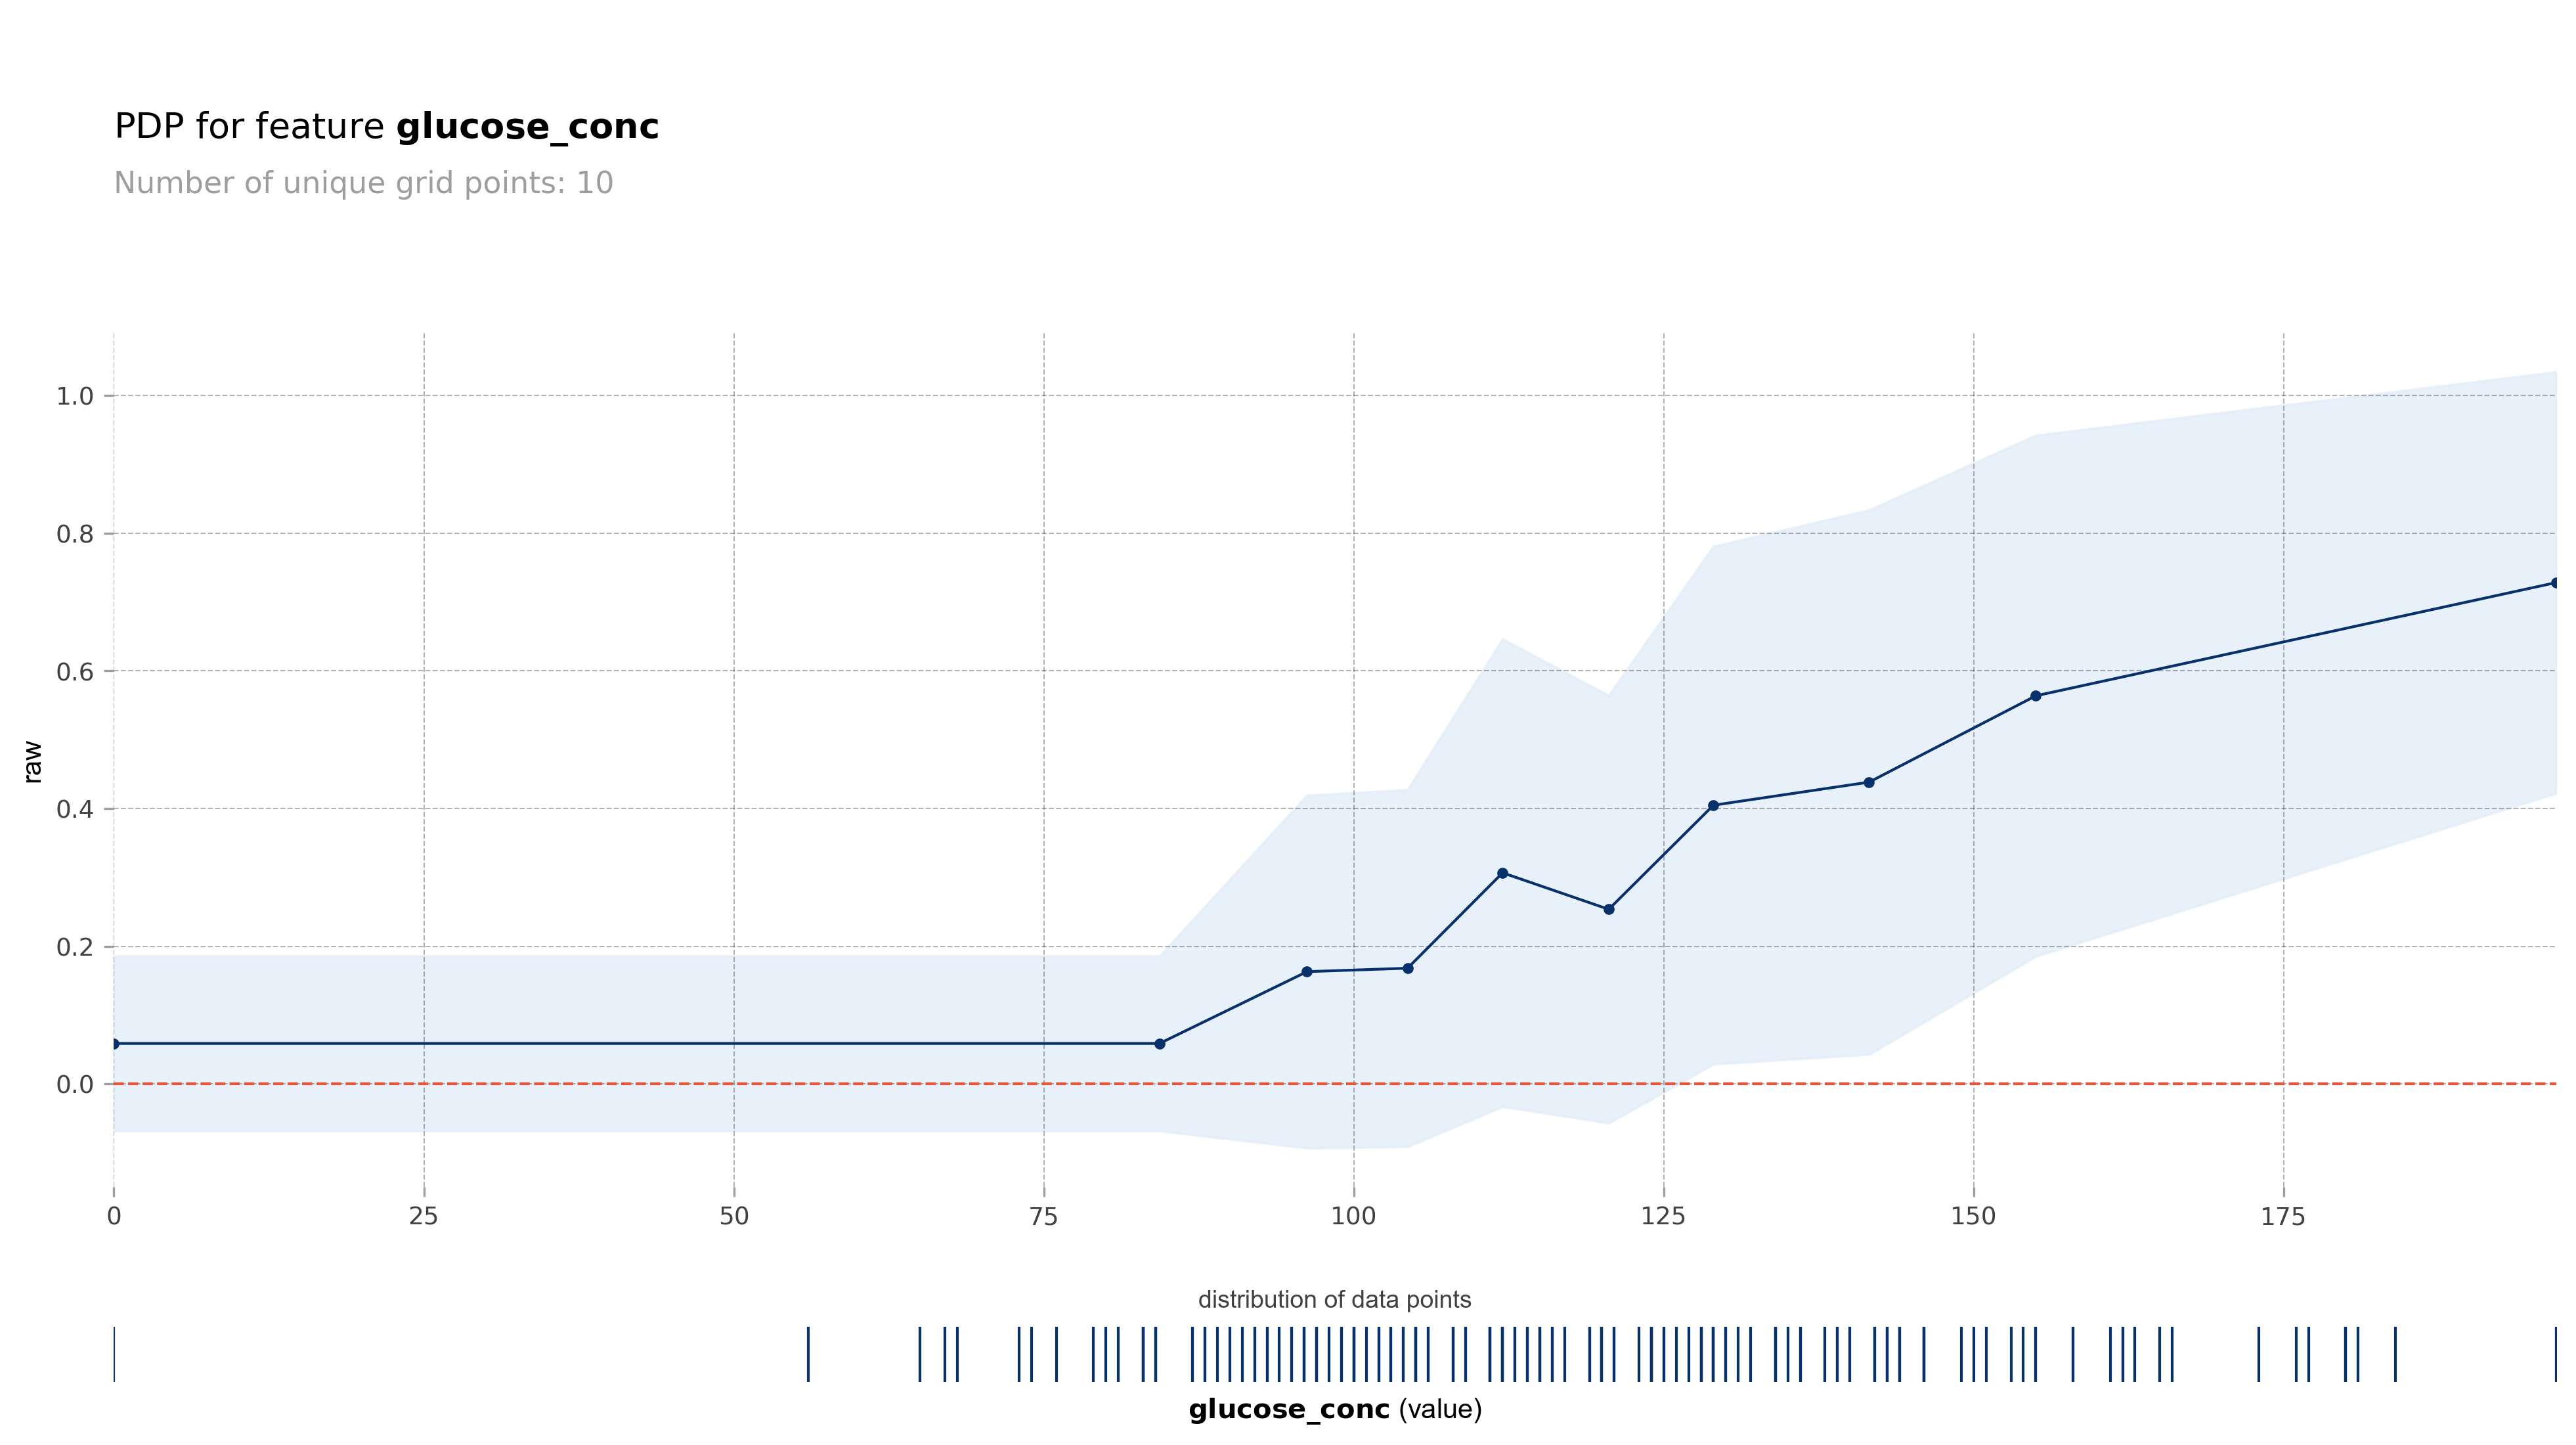

In [27]:
Xy_test=X_test.copy()
features=X_test.columns
Xy_test['target'] = y_test

pdp_res = pdp.PDPIsolate(model=random_xgb.best_estimator_, df=Xy_test, feature="glucose_conc", 
                        feature_name="glucose_conc", model_features=features, n_classes=2)
pdp_res.plot(center=False, plot_lines=False, plot_pts_dist=True,   engine='matplotlib')

The number of data points present is arguably scarce for "glucose_conc" values below 75, which tends to culminate in inferences in those spaces not being the most robust; however, above roughly 80, it seems that higher values of "glucose_conc" are associated with higher average prediction probabilities for testing positive for diabetes.

obtain pred_func from the provided model.


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 100.13it/s]


(<Figure size 4800x2700 with 3 Axes>,
 {'title_axes': <Axes: >,
  'line_axes': [<Axes: ylabel='raw'>],
  'dist_axes': [<Axes: title={'center': 'distribution of data points'}, xlabel='$\\bf{body\\_mass}$ (value)'>]})

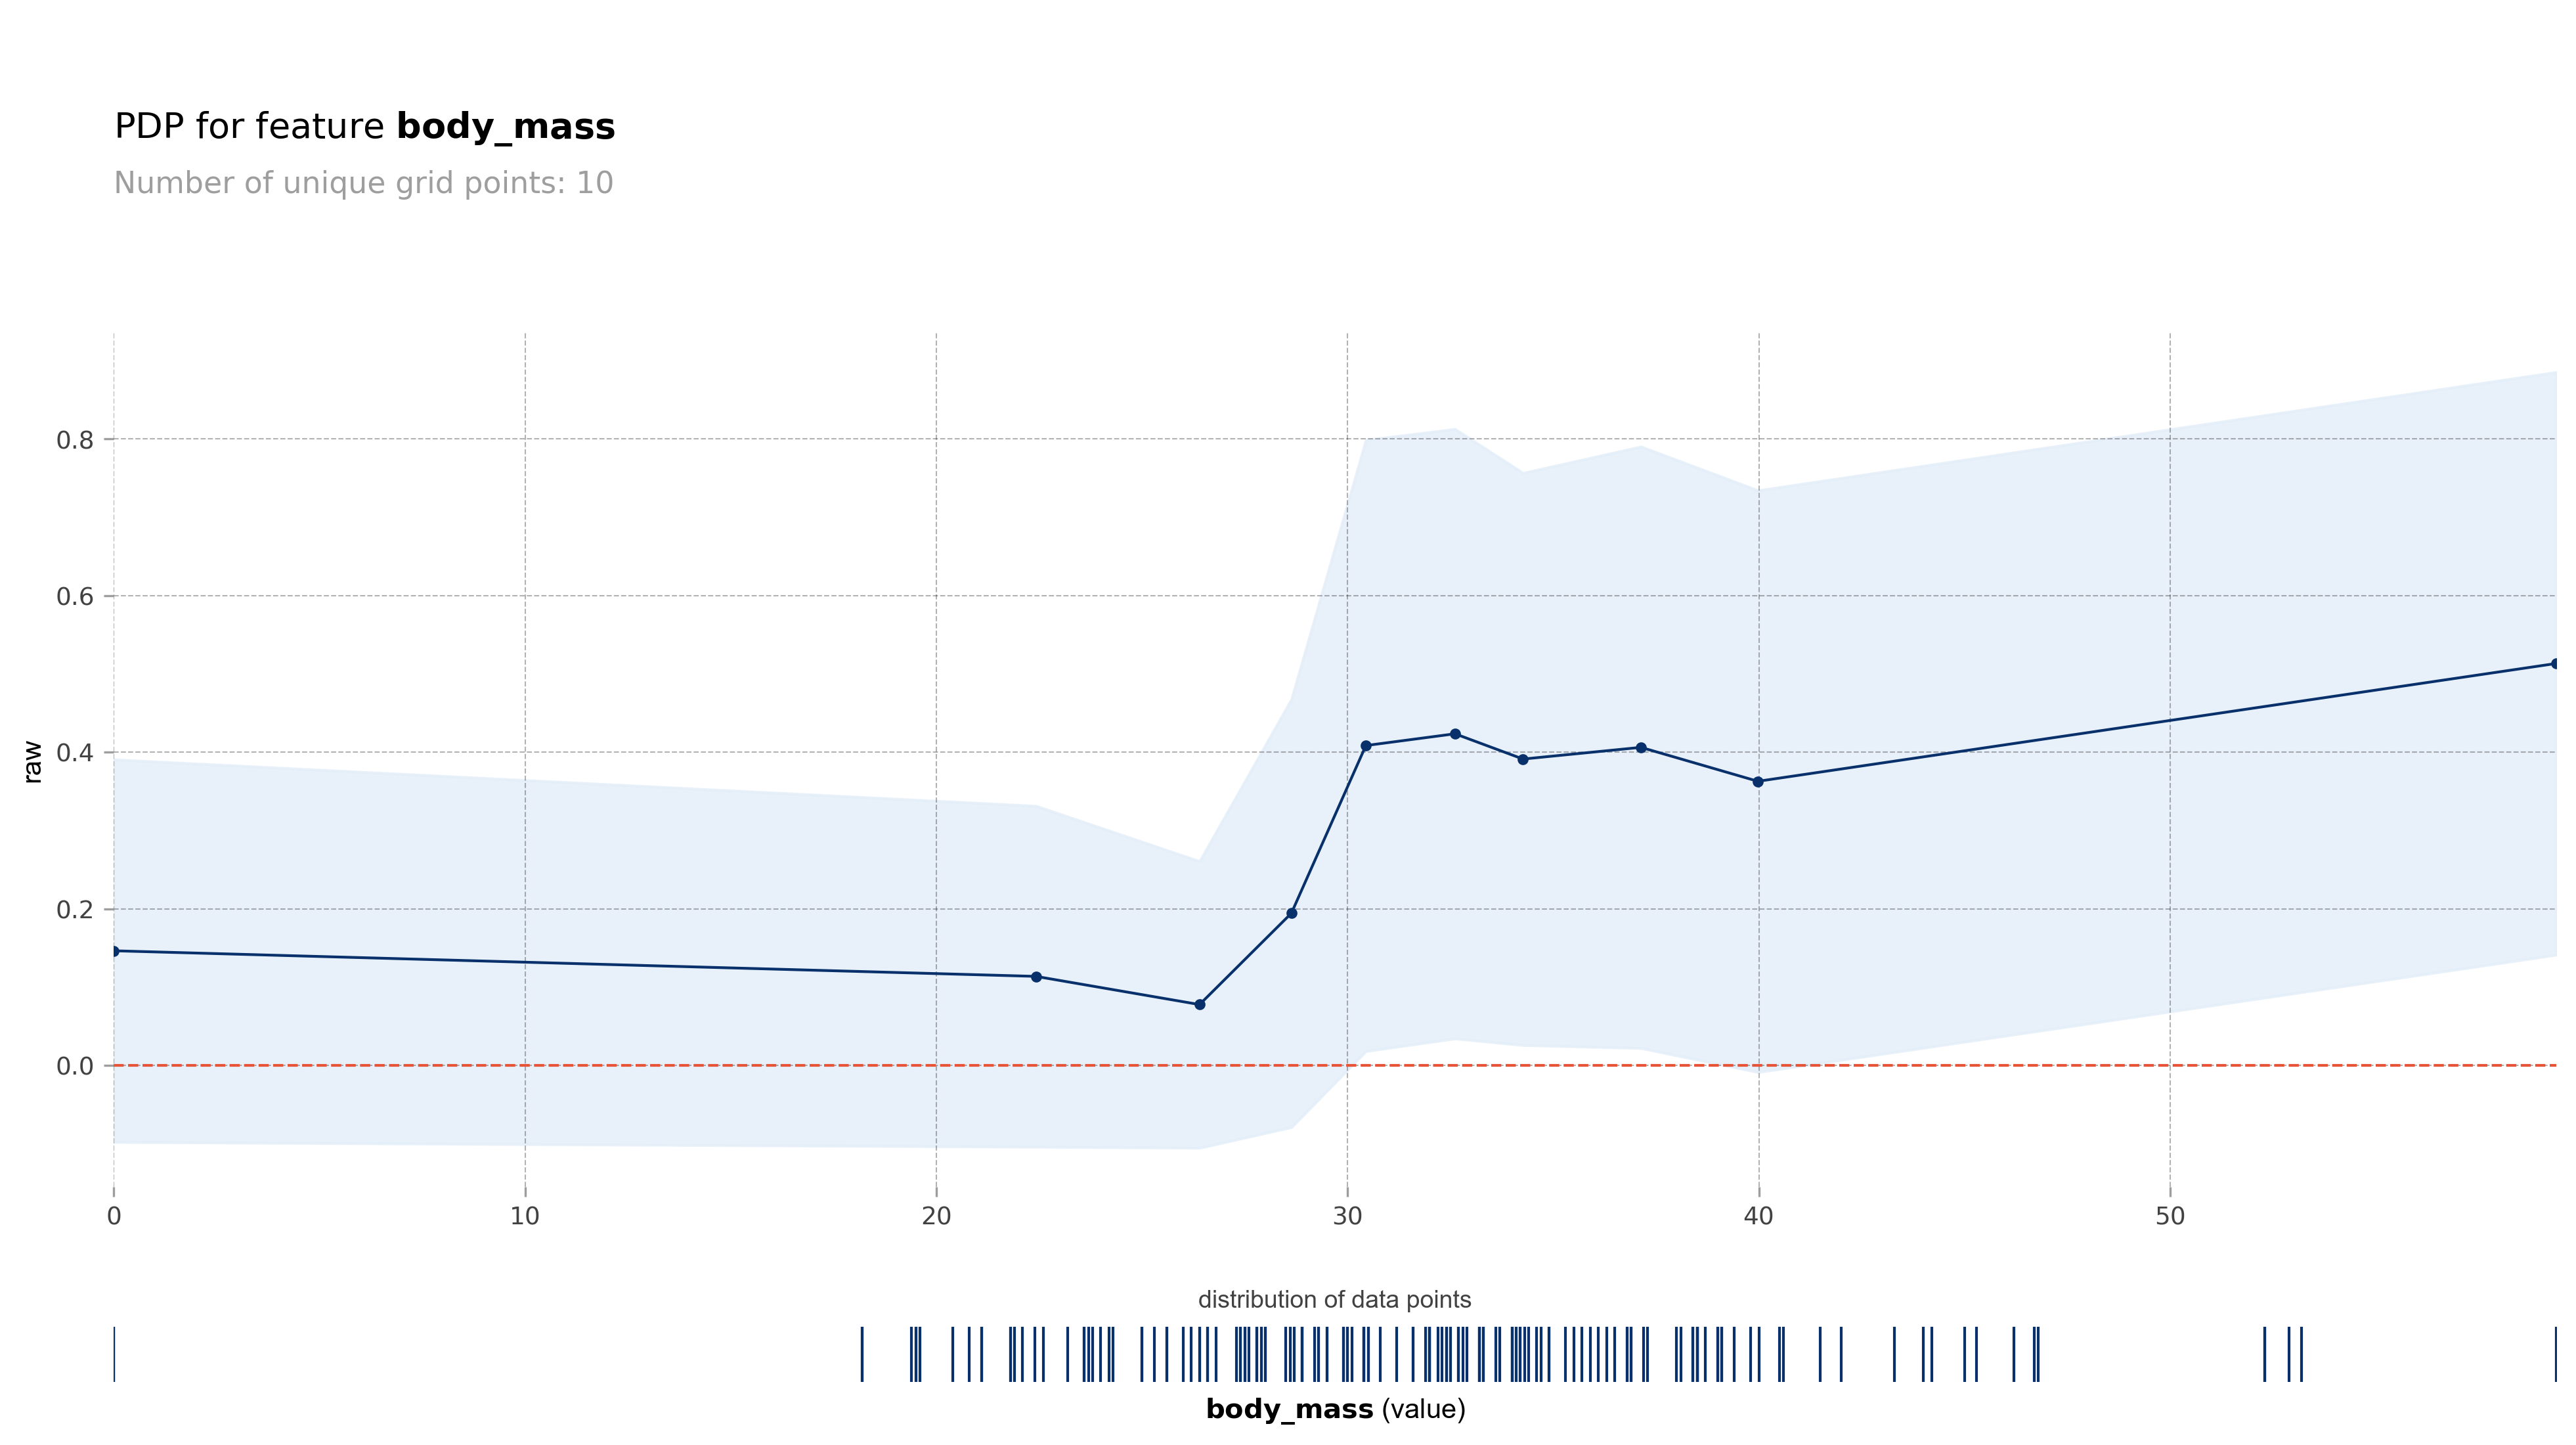

In [28]:
Xy_test=X_test.copy()
features=X_test.columns
Xy_test['target'] = y_test

pdp_res = pdp.PDPIsolate(model=random_xgb.best_estimator_, df=Xy_test, feature="body_mass", 
                        feature_name="body_mass", model_features=features, n_classes=2)
pdp_res.plot(center=False, plot_lines=False, plot_pts_dist=True,   engine='matplotlib')

Although that were eminently few low and high body_mass instances, the overall trend appears to be lower average prediction probabilities until body_mass reaches roughly the value of 25, after which the average predictions begin to rise considerably. 

obtain pred_func from the provided model.


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 105.04it/s]


obtain pred_func from the provided model.


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 105.26it/s]


obtain pred_func from the provided model.


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 105.87it/s]


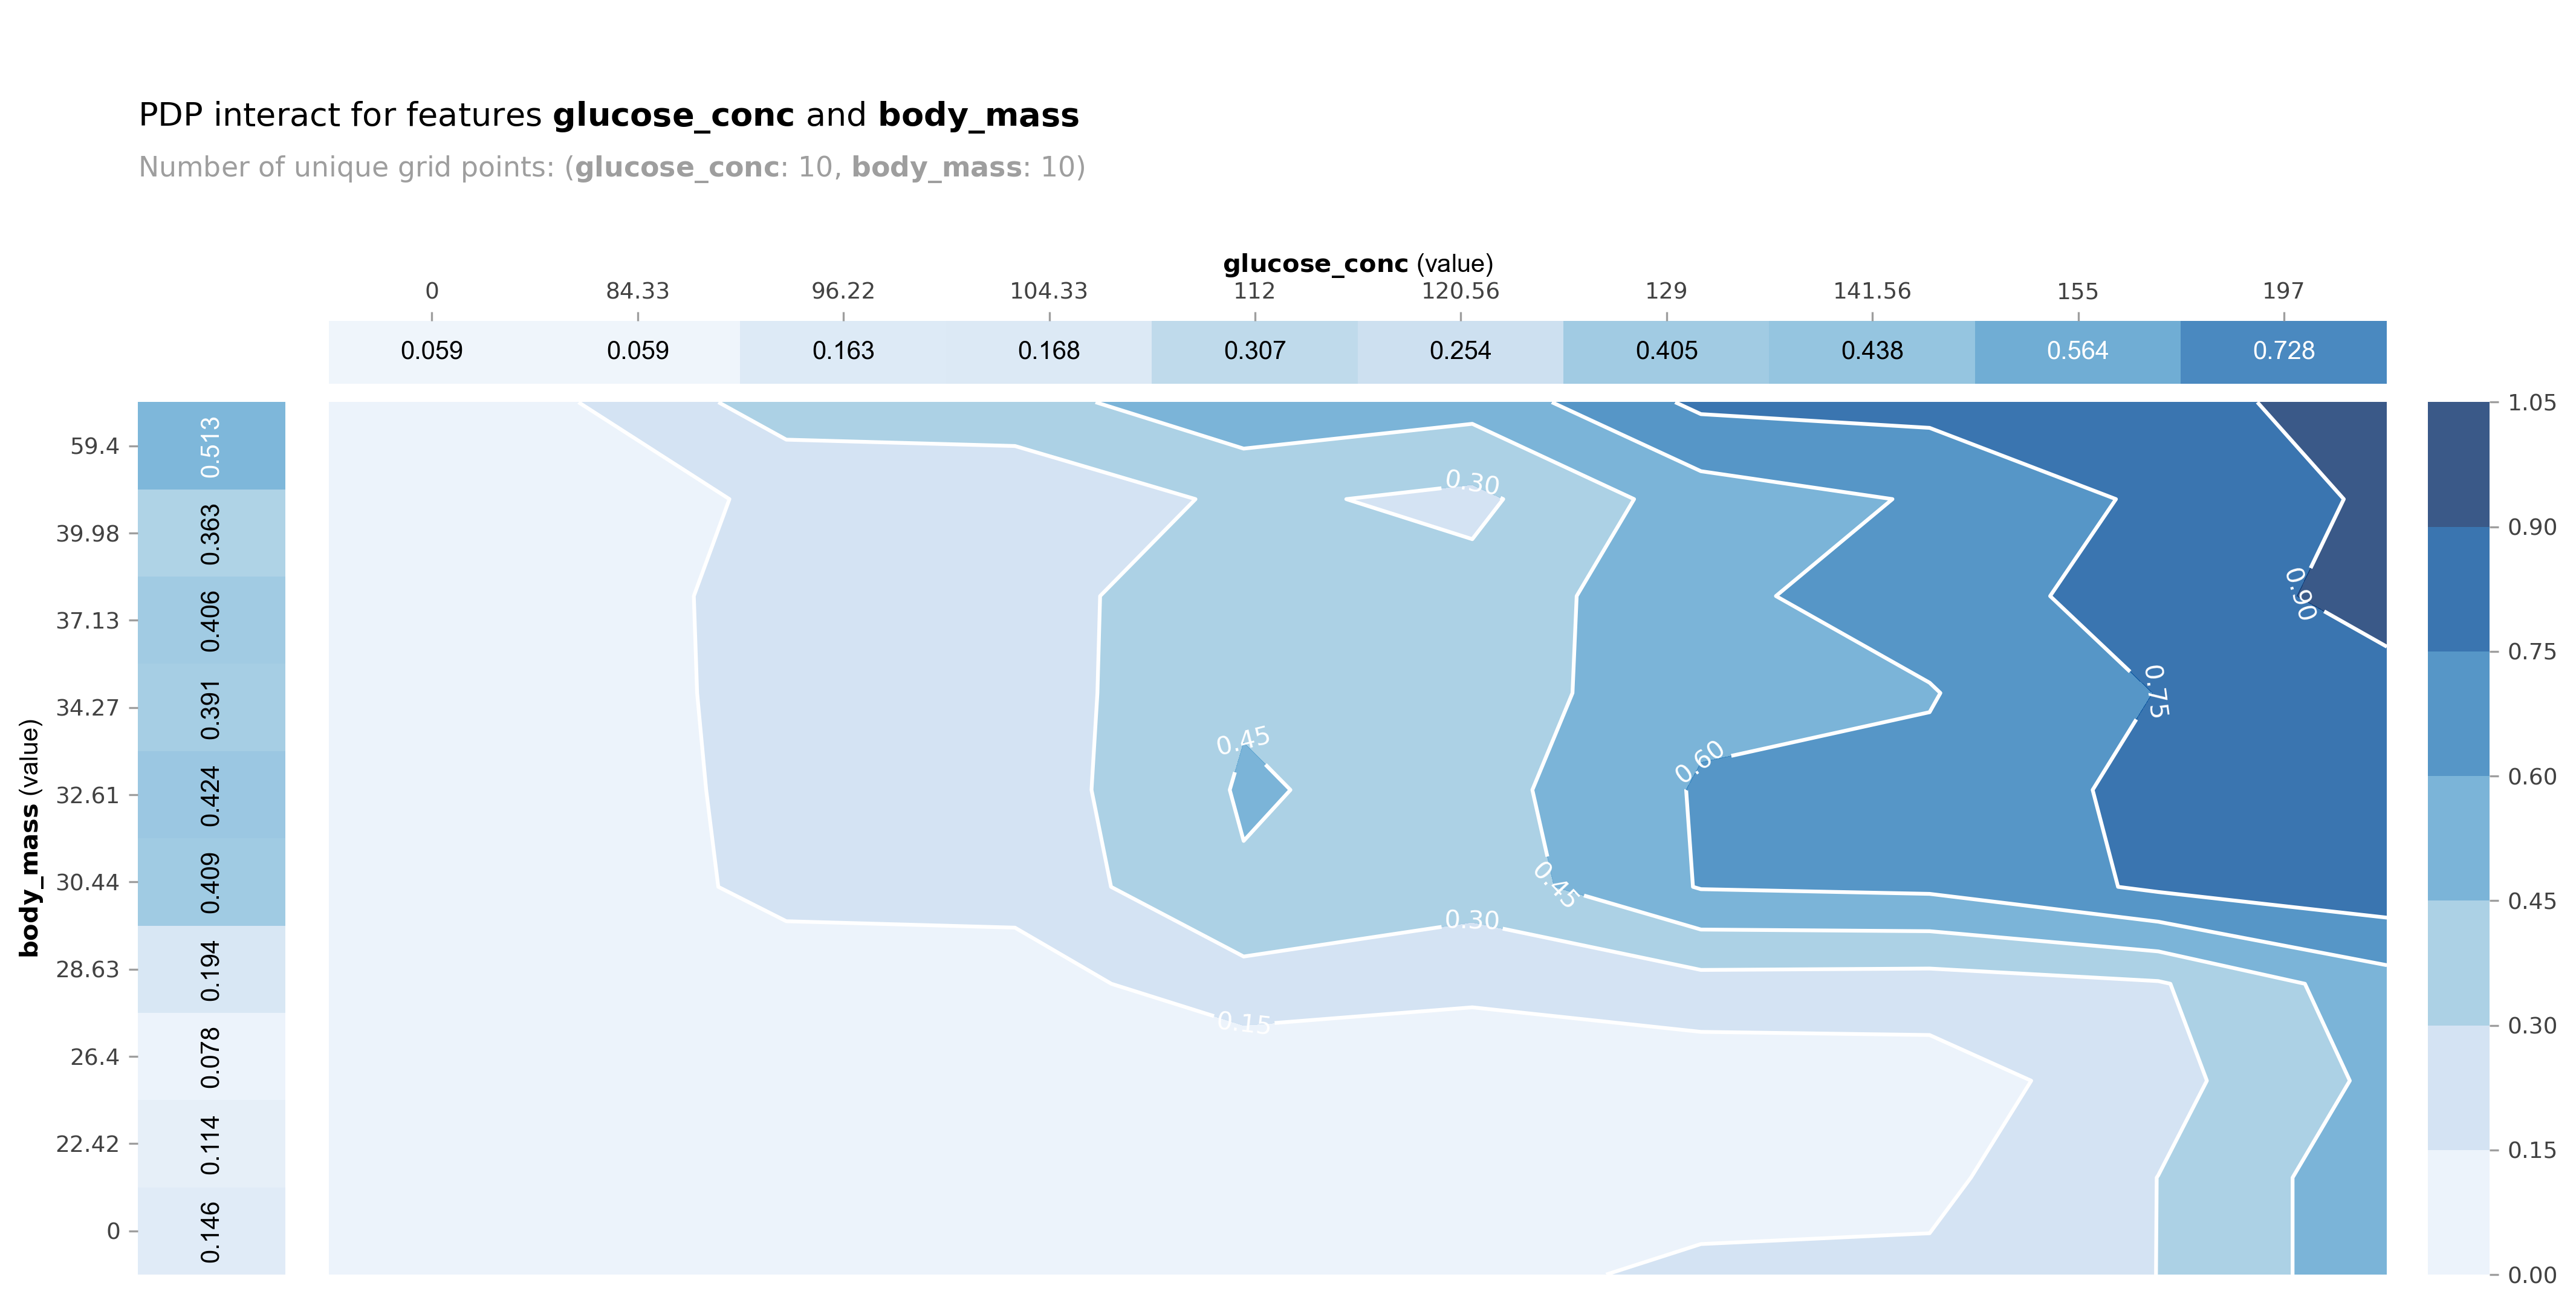

In [29]:
Xy_test=X_test.copy()
features=X_test.columns
Xy_test['target'] = y_test

features_to_plot = ['glucose_conc', 'body_mass']

inter_plot = pdp.PDPInteract(model=random_xgb.best_estimator_, df=Xy_test, model_features=features, 
                                           features=features_to_plot, feature_names=features_to_plot, n_classes=2)
fig, axes =inter_plot.plot( engine='matplotlib', plot_pdp=True)

The lowest predicted probability of being tested positive for diabetes (roughly within 15%) is most likely to occur when the values of body_mass and glucose_conc are below/around approximately 28.63 and 84.33, respetively; notwithstanding, a  low average probability of being tested for diabetes is also likely to ensue when only body_mass or glucose_conc alone report low values (if it is body_mass that is low, glucose_conc should not reach 155). 

Mind that there were few instances within these ranges, and ergo there may not be sufficient evidence to confidently support the results. 

### 1.9. Find the first point misclassified by the model. 

### What is the probability that it belongs to class 1 found by the model? 

### Use LIME to see the explanation for this prediction by using only 3 features to explain the model, with 200 samples; also, set the random state to 42 when defining the explainer. 

### What are the features that LIME uses to explain the prediction? What are the features that contribute to the wrong class, i.e., the class predicted by the model? (5pt)

In [30]:
import lime
import lime.lime_tabular

#defining the explainer

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns,
                                                   class_names=[0, 1], mode='classification',
                                                   verbose=True,
                                                   discretize_continuous=True, random_state=42)

In [31]:
Xy_test=X_test.copy()
Xy_test['y_test']=y_test
Xy_test['y_pred']=y_pred
Xy_test[Xy_test.y_test!=Xy_test.y_pred].head(1)

num_pregnancy  glucose_conc  blood_pressure  skin_fold  serum  body_mass  \
168              6           104              74         18    156       29.9   

     diabetes_pedigree  age  y_test  y_pred  
168              0.722   41       1       0

In [32]:
data_for_prediction=Xy_test[Xy_test.y_test!=Xy_test.y_pred].head(1).drop(columns=['y_test','y_pred'])
random_xgb.best_estimator_.predict_proba(data_for_prediction.values.reshape(1, -1))

array([[0.9359639 , 0.06403607]], dtype=float32)

or

In [33]:
incorrect_pred = (y_test != y_pred)

index_inc_pred = X_test[incorrect_pred].index #attaining the indexes of all wrongly-classified instances

first_incorrect = X_test.loc[index_inc_pred[0]] #fetching the first incorrectly-classified instance
first_incorrect

num_pregnancy          6.000
glucose_conc         104.000
blood_pressure        74.000
skin_fold             18.000
serum                156.000
body_mass             29.900
diabetes_pedigree      0.722
age                   41.000
Name: 168, dtype: float64

In [34]:
y_pred_prob = random_xgb.predict_proba(X_test) #calculate prediction probabilities for all instances.

all_pred_prob = pd.DataFrame(y_pred_prob, index = y_test.index) #placing these in a dataframe

first_incorrect_pred_prob = all_pred_prob.loc[index_inc_pred[0]]
#finding the first incorrectly-classified instance's prediction probabilities

first_incorrect_pred_prob = first_incorrect_pred_prob.values.reshape(1,-1) #converting it to an array format
first_incorrect_pred_prob

array([[0.9359639 , 0.06403607]], dtype=float32)

In [35]:
print(f"The probability that this instance belongs to class 1 is {first_incorrect_pred_prob[0][1]}.")

The probability that this instance belongs to class 1 is 0.06403607130050659.


In [36]:
exp_lime_pipe = explainer.explain_instance(first_incorrect,
                                           predict_fn=random_xgb.best_estimator_.predict_proba, 
                                           num_samples=200, num_features=3)

Intercept 0.4767040925692059
Prediction_local [0.25712666]
Right: 0.06403607


In [37]:
exp_lime_pipe.show_in_notebook(show_table = True, show_all= False)

In [38]:
cols = []
vals = []
for i, j  in exp_lime_pipe.local_exp[1]:
          
    cols.append(X_test.columns[i])
    vals.append(j)

pd.DataFrame([vals], columns=cols)

glucose_conc  diabetes_pedigree  num_pregnancy
0     -0.245971           0.091675      -0.065281

In [39]:
prediction_made = pd.Series(y_pred, index=y_test.index).loc[index_inc_pred[0]]
true_value = y_test.loc[index_inc_pred[0]]

print(f"The prediction made was {prediction_made}, yet the true value is {true_value}.")

The prediction made was 0, yet the true value is 1.


In [40]:
print('Features used by LIME to explain the prediction:', exp_lime_pipe.as_list())

print()

contributing_features = [X_test.columns[idx] for idx, weight in exp_lime_pipe.as_map()[1] if weight < 0]
print('Features contributing to wrong class:', contributing_features)

Features used by LIME to explain the prediction: [('99.00 < glucose_conc <= 117.00', -0.24597139881708852), ('diabetes_pedigree > 0.61', 0.09167462650800355), ('3.00 < num_pregnancy <= 6.00', -0.06528065855651176)]

Features contributing to wrong class: ['glucose_conc', 'num_pregnancy']


The three features displayed by LIME were glucose_conc, diabetes_pedigree and age, and those that contributed to the incorrect prediction (0) were glucose_conc and num_pregnancy, with a contribution of roughly 0.25 and 0.07, respectively.

### 1.10. What is the most important feature in the testing set according to Shap. Explain in one sentence how the values of this feature impact the prediction (3pt)

ExactExplainer explainer: 156it [00:41,  3.72it/s]                                                                     


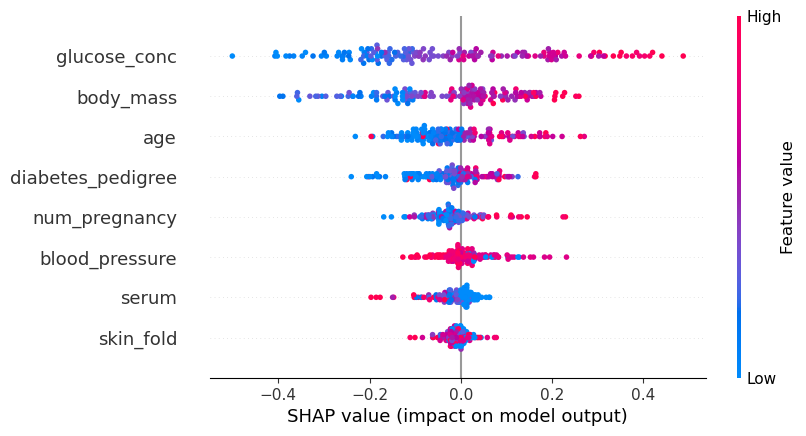

In [41]:
import shap
explainer = shap.Explainer(random_xgb.predict_proba, X_train)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values[:,:,1])

The most important feature according to Shap is "glucose_conc" and it seems that lower values of this feature (in blue) contribute to the prediction of class 0, whereas high values of this feature (in red) contribute to the prediction of class 1 (testing positive for diabetes).

## Question 2

**Total 17 points**

In this question we will use the MNIST digits dataset. However, to reduce the dataset size, we will only classify the first five classes. The question must be solved with pytorch and lightning.

1. Import the csv file "HW3_Q2data.csv" into pandas dataframe, check the number of rows, check the data types, view the first 5 rows, check class distribution (1pt)
   
As the images have been compressed into a flattened format, restore the data to its original format with dimensions of 28 pixels in height and 28 pixels in width by transforming the data and labels to a numpy object using to_numpy() and the data through reshape(-1,28,28)


2. Visualize the first image of the dataset (1pt)
3. Split the dataset into training, validation, and testing sets with proportions of 60%, 30%, and 10% respectively. After performing the split, print the proportion of each set (1pt)
4. Construct a TensorDataset for each set with the resulting tensors. Set the torch and numpy seed to 42. Instantiate a DataLoader for each TensorDataset with a batch size of 64 (2pt)
5. Define a fully connected network with one hidden layer containing 64 nodes, and include any other required layers. Specify the appropriate loss function and initialize an Adam optimizer with a learning rate of 0.0005. Set up a model saving checkpoint and early stopping to stop if there isn't any improvement in validation accuracy after 6 epochs. Prepare the function for printing and visualizing the metrics per epoch.  (6pt)
6. Train the fully connected network for 50 epochs. Set the torch and numpy seed to 42. Plot training and validation accuracy and loss. What was the validation accuracy in the last epoch and why did it stop there? Is the model overfitting? Visualize the model architecture. (5pt)
7. Evaluate the best model's accuracy on the test set (1pt)

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 2.1. Import the csv file "HW3_Q2data.csv" into pandas dataframe, check the number of rows, check the data types, view the first 5 rows, check class distribution (1pt)

In [43]:
df2 = pd.read_csv('HW3_Q2.csv')
df2

0  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  \
0      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
1      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
2      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
3      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
4      0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
...   .. .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
35730  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
35731  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
35732  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
35733  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
35734  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   

       782  783  label  
0        0    0      0  
1        0    0      4  
2        0    0      1  
3        0    0      2  
4        0    0      1  
...    ...  ...    ...  
35730    0    0      0  
35731    0    0      1  
35732    0    0      2  
35733    0    0      3  
35734    0    0      4  

[35735 rows x 785 columns]

In [44]:
df2.shape[0]

35735

In [45]:
df2.dtypes

0        int64
1        int64
2        int64
3        int64
4        int64
         ...  
780      int64
781      int64
782      int64
783      int64
label    int64
Length: 785, dtype: object

In [46]:
df2.head()

0  1  2  3  4  5  6  7  8  9  ...  775  776  777  778  779  780  781  782  \
0  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
1  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
2  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
3  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   
4  0  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0    0   

   783  label  
0    0      0  
1    0      4  
2    0      1  
3    0      2  
4    0      1  

[5 rows x 785 columns]

In [47]:
df2['label'].value_counts()

label
1    7877
3    7141
2    6990
0    6903
4    6824
Name: count, dtype: int64

### As the images have been compressed into a flattened format, restore the data to its original format with dimensions of 28 pixels in height and 28 pixels in width by transforming the data and labels to a numpy object using to_numpy() and the data through reshape(-1,28,28)

In [48]:
data = df2.drop(columns=['label']).to_numpy()
labels = df2['label'].to_numpy()

data = data.reshape(-1,28,28)

In [49]:
data.shape

(35735, 28, 28)

### 2.2. Visualize the first image of the dataset (1pt)

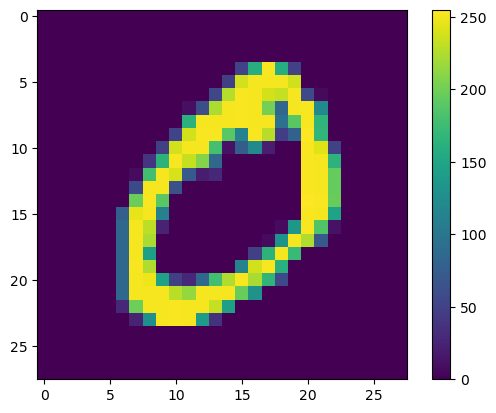

In [50]:
plt.figure()
plt.imshow(data[0])
plt.colorbar()
plt.grid(False)
plt.show()

### 2.3. Split the dataset into training, validation, and testing sets with proportions of 60%, 30%, and 10% respectively. After performing the split, print the proportion of each set (1pt)

In [51]:
from sklearn.model_selection import train_test_split

# Split data into training, validation, and testing sets
X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=(1/3), random_state=42)

print(len(X_train)/len(data))
print(len(X_val)/len(data))
print(len(X_test)/len(data))

0.5999720162305863
0.30001399188470684
0.10001399188470687


### 2.4. Construct a TensorDataset for each set with the resulting tensors. Set the torch and numpy seed to 42. Instantiate a DataLoader for each TensorDataset with a batch size of 64 (2pt)

In [52]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset

torch.manual_seed(42)
np.random.seed(42)

# train_set = TensorDataset(torch.Tensor(X_train), torch.LongTensor(y_train))
# valid_set = TensorDataset(torch.Tensor(X_val), torch.LongTensor(y_val))
# test_set = TensorDataset(torch.Tensor(X_test), torch.LongTensor(y_test))

# or

# train_set = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train))
# valid_set = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val))
# test_set = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test))

# or

train_set = TensorDataset(torch.Tensor(X_train), torch.tensor(y_train))
valid_set = TensorDataset(torch.Tensor(X_val), torch.tensor(y_val))
test_set = TensorDataset(torch.Tensor(X_test), torch.tensor(y_test))

In [53]:
torch.Tensor(X_train).dtype

torch.float32

In [54]:
torch.tensor(y_train).dtype, torch.LongTensor(y_train).dtype

(torch.int64, torch.int64)

In [55]:
torch.manual_seed(42)
np.random.seed(42)

batch_size = 64
train_loader= DataLoader(train_set, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_size)
test_loader = DataLoader(test_set, batch_size=batch_size)

### 2.5. Define a fully connected network with one hidden layer containing 64 nodes, and include any other required layers. Specify the appropriate loss function and initialize an Adam optimizer with a learning rate of 0.0005. Set up a model saving checkpoint and early stopping to stop if there isn't any improvement in validation accuracy after 6 epochs. Prepare the function for printing and visualizing the metrics per epoch (6pt)

In [56]:
import torch.nn as nn
import pytorch_lightning as pl
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, TensorDataset
import torch.optim as optim
from torchinfo import summary
from torchmetrics.classification import Accuracy
from torchmetrics.regression import MeanAbsoluteError
from  pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [57]:
class Model(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(task="multiclass", num_classes=5)
        self.val_acc = Accuracy(task="multiclass", num_classes=5)
        self.test_acc = Accuracy(task="multiclass", num_classes=5)


    def forward(self, x):
        return self.model(x)  
        
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.train_acc(preds, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.val_acc(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.test_acc(preds, y)
        self.log("test_acc", acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0005)

In [58]:
early_stop_cb = EarlyStopping(
    monitor="val_acc",
    patience=6,
    mode="max",
    verbose=True
)

In [59]:
checkpoint_cb = ModelCheckpoint(
    monitor="val_acc",
    filename="best-hw3",
    save_top_k=1,
    mode="max"
)

In [60]:
def plot_performance(metrics_path):
    if os.path.exists(metrics_path+'/lightning_logs'):
      versions = [d for d in os.listdir(metrics_path+'/lightning_logs') if d.startswith("version_")]
      latest_version = max(versions, key=lambda x: int(x.split("_")[1]))
    else:
      latest_version='version_0'
    metrics_df = pd.read_csv(metrics_path+'/lightning_logs/'+latest_version+'/metrics.csv')

    # Since the logger saves training and validation metric at different times,
    # when it saves training, validation metrics are left as nan, and the other way around as well.
    # So below we just look for non nan values
    metrics_df = metrics_df.groupby(['epoch', 'step'], sort=False, as_index=False).last().reset_index(drop=True)
    # epochs are recorderd as starting from 0
    metrics_df['epoch']=metrics_df['epoch']+1
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(metrics_df['epoch'], metrics_df['train_loss'], label='Training Loss')
    ax[0].plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss')
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].set_title("Training and Validation Loss")
    ax[0].legend()

    ax[1].plot(metrics_df['epoch'], metrics_df['train_acc'], label='Training Accuracy')
    ax[1].plot(metrics_df['epoch'], metrics_df['val_acc'], label='Validation Accuracy')
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Training and Validation Accuracy")
    ax[1].legend()

    plt.tight_layout()

    return metrics_df

### 2.6. Train the fully connected network for 50 epochs. Set the torch and numpy seed to 42. Plot training and validation accuracy and loss. What was the validation accuracy in the last epoch and why did it stop there? Is the model overfitting? Visualize the model architecture. (5pt)

In [61]:
#import logging
#logging.getLogger("pytorch_lightning").setLevel(logging.ERROR) #removes the gpu, tpu, hpu, etc. message
import warnings 
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

model = Model()

csv_logger = CSVLogger(save_dir='hw3-model-csv')
tb_logger = TensorBoardLogger(save_dir='hw3-model-tb')

trainer = pl.Trainer(max_epochs=50, callbacks=[early_stop_cb, checkpoint_cb], accelerator="auto", logger = [tb_logger, csv_logger], 
                     enable_progress_bar=False) # speeds up the code and removes the dataloader messages
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | Sequential         | 50.6 K | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
50.6 K    Trainable params
0         Non-trainable params
50.6 K    Total params
0.202     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
Metric val_acc improved. New best score: 0.972
Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.981
Metric val_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.985
Monitored metric val_acc did not improve in the last 6 records. Best s

In [62]:
trainer.current_epoch

10

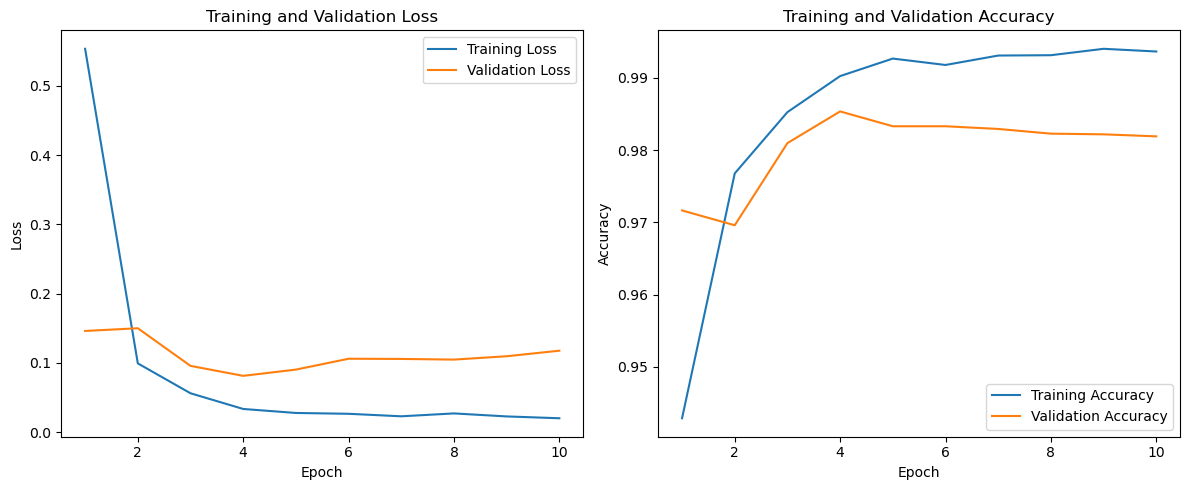

In [63]:
metrics_df=plot_performance('hw3-model-csv')

or

In [64]:
# %load_ext tensorboard
# %tensorboard --logdir hw3-model-tb/lightning_logs/

In [65]:
metrics_df

epoch  step  train_acc  train_loss   val_acc  val_loss
0      1   334   0.942864    0.553659  0.971644  0.146150
1      2   669   0.976772    0.099318  0.969592  0.150054
2      3  1004   0.985261    0.056149  0.980972  0.095715
3      4  1339   0.990252    0.033480  0.985356  0.081325
4      5  1674   0.992677    0.027704  0.983304  0.090345
5      6  2009   0.991791    0.026518  0.983304  0.106006
6      7  2344   0.993097    0.022887  0.982931  0.105744
7      8  2679   0.993144    0.027054  0.982278  0.104788
8      9  3014   0.994030    0.022706  0.982184  0.109626
9     10  3349   0.993657    0.020075  0.981905  0.117632

<u>What was the validation accuracy in the last epoch and why did it stop there?</u>

The model stopping evaluating after 10 epochs.

In the 4th epoch, val_accuracy consisted of 0.9853: a result that did not improve in the six subsequent epochs, leading to the early stopping.

In the 10th epoch, the val_accuracy was 0.9819.

<u>Is the model overfitting?</u>

Both the accuracy and loss curves mirror each other to a certain extent, despite the slightly more pronounced volatility in the validation curves. The curves follow the same trajectory throughout most epochs but, toward the final epochs, it can be perused that the validation curves begin to shift to the opposite direction: this divergence of behavior likely alludes to the possibility of overfitting if the model continues to be trained (ergo, early stopping was germane), as the training loss and accuracy continue to improve while the validation counterparts deteriorate. 

In [66]:
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 5]                    --
├─Sequential: 1-1                        [1, 5]                    --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 64]                   50,240
│    └─ReLU: 2-3                         [1, 64]                   --
│    └─Linear: 2-4                       [1, 5]                    325
Total params: 50,565
Trainable params: 50,565
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.21

### 2.7. Evaluate the best model's accuracy on the test set (1pt)

In [67]:
best_path = checkpoint_cb.best_model_path
#print("Best checkpoint path:", best_path)

In [68]:
best_model = Model.load_from_checkpoint(best_path)
trainer.test(best_model, dataloaders=test_loader)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9834918975830078     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9834918975830078}]